In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def f(x):
    return 3*x**2 - 4*x + 5

In [28]:
f(3.0)

20.0

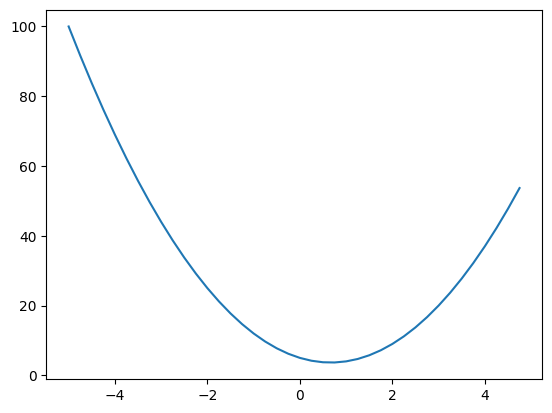

In [29]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys, )

In [30]:
h = 0.00000001
x = 2/3
diff = (f(x + h) - f(x))/h
print("diff =",diff)

diff = 0.0


In [31]:
class value:

    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self.prev = set(children)
        self.op = op
        self.label = label
        self.grad = 0.0
        self.backwards = lambda : None

    def __repr__(self):
        return f"value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data + other.data, (self, other), '+')

        def backwards():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out.backwards = backwards
        return out

    def __mul__(self, other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data * other.data, (self, other), '*')

        def backwards():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
            #  dL/dz = dL/dx * dx/dz 

        out.backwards = backwards
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out  = value(t, (self, ), 'tanh')

        def backwards():
            self.grad += (1-t**2)*out.grad
            
        out.backwards = backwards
        return out
    
    def backprop(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node.backwards()       


In [32]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left→right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # value node
        dot.node(
            name=uid,
            label="{%s | data %.4f | grad %.4f)}" % (n.label, n.data, n.grad),
            shape='record'
        )

        if n.op:
            # operation node
            op_uid = uid + n.op
            dot.node(name=op_uid, label=n.op)

            # connect op → value
            dot.edge(op_uid, uid)

    for n1, n2 in edges:
        # connect value → op
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot


In [34]:

# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [35]:

o.backprop()


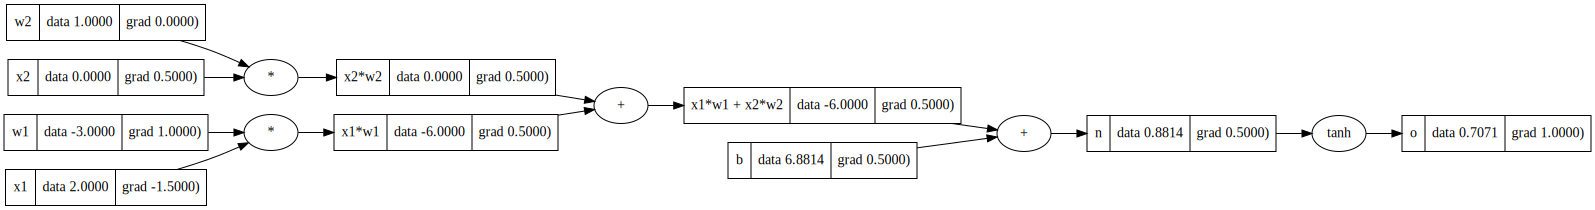

In [36]:

draw_dot(o)

In [85]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in  zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for i in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


value(data = -0.27120415592362646)

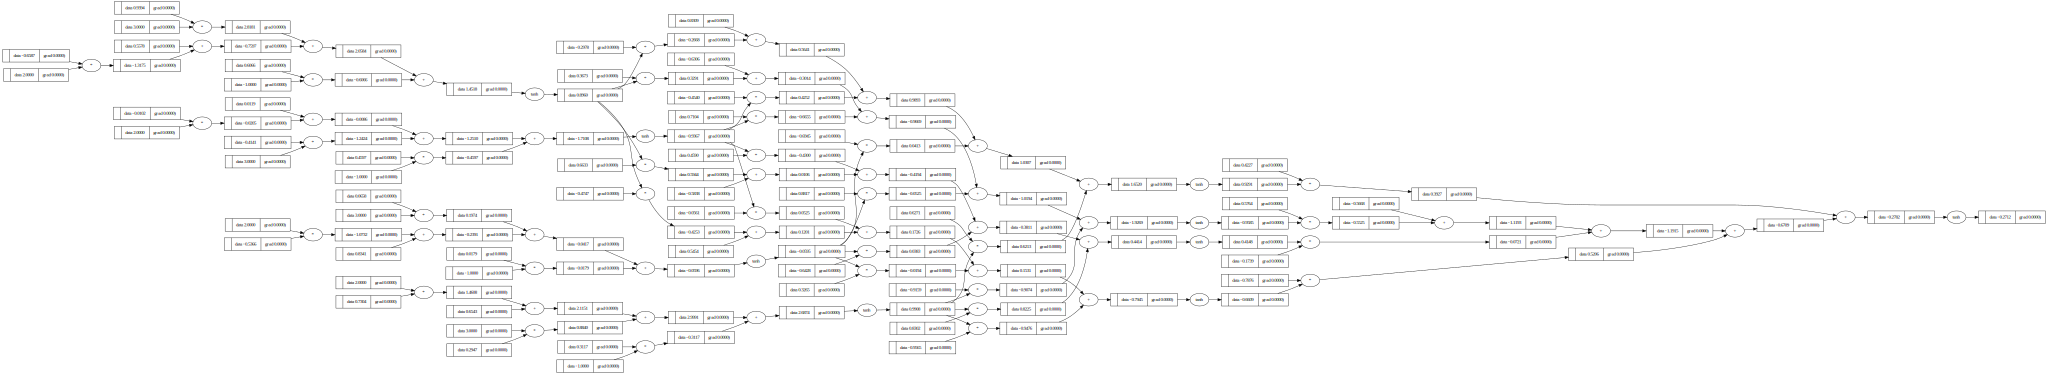

In [86]:
draw_dot(n(x))